In [1]:
import numpy as np
import torch
import yaml

## Clear cache
# torch.cuda.empty_cache()

from trainers.pl_trainer import SRSegLit
from trainers.dlinknet_trainer import RoadTrainer
from trainers.unetpp_trainer import BuildingTrainer

from utils.cloud_detection import (get_s1_col, get_s2cloudless_collection, 
                                   get_matching_s1_s2, get_images)

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


In [ ]:
## 0
LAT, LON =  42.80091909991168, -1.6790441077503147
START_DATE = "2021-01-01"
END_DATE = "2021-12-30"

## 1
LAT, LON =  40.138, -3.853
START_DATE = "2023-03-19"
END_DATE = "2023-03-30"

## 2
LAT, LON =  40.318, -3.702
START_DATE = "2025-01-15"
END_DATE = "2025-01-30"

## 3
LAT, LON =  40.547, -3.690
START_DATE = "2025-01-15"
END_DATE = "2025-01-30"

In [25]:
LAT, LON =  42.80365265672157, -1.6873541463870083          
START_DATE = "2021-06-01"
END_DATE = "2021-06-28"

## Default download parameters
CLOUD_FRACTION = 0.5
PATCH_SIZE = 64
S2_BANDS = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B11", "B12", "AOT"]
S1_BANDS = ["VV", "VH"]

# Apply the cloudless filter to the collection
image_collection_s2 = get_s2cloudless_collection(LAT, LON, START_DATE, END_DATE, CLOUD_FRACTION, PATCH_SIZE)
image_collection_s1 = get_s1_col(LAT, LON, START_DATE, END_DATE, PATCH_SIZE, orbit_pass='DESCENDING')

matched_s1_col, matched_s2_col, dates = get_matching_s1_s2(image_collection_s1, image_collection_s2)

# Get the images
s2_images, s2_profile = get_images(LAT, LON, matched_s2_col, S2_BANDS, PATCH_SIZE)
s1_images, s1_profile = get_images(LAT, LON, matched_s1_col, S1_BANDS, PATCH_SIZE)

print(f"Number of S2 images: {len(s2_images)}, Number of S1 images: {len(s1_images)}")

Original collection size: 6
Collection with cloud score size: 6
Filtered collection size: 3
Original collection size: 9
Filtered collection size: 9
Found 3 valid image pairs.
Matching dates: ['S1:2021-06-01_S2:2021-06-02', 'S1:2021-06-07_S2:2021-06-07', 'S1:2021-06-12_S2:2021-06-12']
UTM CRS: 32630
UTM CRS: 32630
Number of S2 images: 3, Number of S1 images: 3


In [50]:
ro_ckpt_path = "../checkpoints/dlinknet-bestmodel.ckpt"
ro_cfg_path = "../configs/dlink_config.yaml"  

with open(ro_cfg_path, 'r') as f:
    ro_cfg = yaml.safe_load(f)

out_arrays_only_road = []
for i, (s1_arr, s2_arr) in enumerate(zip(s1_images, s2_images)):
    s2_fullbands = np.array(s2_arr["image"])  # (13, H, W)
    s1_np = np.array(s1_arr["image"])  # (2, H, W)

    # Normalize S2 bands to 0-1
    s2_np = s2_fullbands[[3, 2, 1, 7, 10, 11]] / 10_000  # RGB, NIR, SWIR1, SWIR2

    # Combine S2+S1 for input to model
    input_img = np.concatenate((s2_np, s1_np), axis=0)  # (C, H, W)
    mean = np.array(ro_cfg['normalize']['mean']).reshape(-1, 1, 1)
    std = np.array(ro_cfg['normalize']['std']).reshape(-1, 1, 1)
    input_img = (input_img - mean) / std
    input_tensor = torch.tensor(input_img).unsqueeze(0).float()

    # Load model
    ckpt = torch.load(ro_ckpt_path, map_location='cpu')
    model2 = RoadTrainer(ro_cfg)    
    model2.load_state_dict(ckpt["state_dict"])
    model2.eval()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model2 = model2.to(device).float()
    input_tensor = input_tensor.to(device).float()

    with torch.no_grad():
        road_logits = model2(input_tensor)
        road_pred = torch.sigmoid(road_logits).squeeze(0).cpu().numpy()

    # Save the predictions
    out_arrays_only_road.append({
        "date": s2_arr["date"],
        "pred": road_pred,
        "profile": s2_profile
    })

    print(f"Processed image {i+1}/{len(s2_images)}: {s2_arr['date']}")

Processed image 1/4: 2023-03-19 11:10:05
Processed image 2/4: 2023-03-22 11:20:01
Processed image 3/4: 2023-03-27 11:20:06
Processed image 4/4: 2023-03-29 11:10:04


In [51]:
bu_ckpt_path = "../checkpoints/unetpp-bestmodel.ckpt"
bu_cfg_path = "../configs/unetpp_config.yaml"  

with open(bu_cfg_path, 'r') as f:
    bu_cfg = yaml.safe_load(f)

out_arrays_only_building = []
for i, (s1_arr, s2_arr) in enumerate(zip(s1_images, s2_images)):
    s2_fullbands = np.array(s2_arr["image"])  # (13, H, W)
    s1_np = np.array(s1_arr["image"])  # (2, H, W)

    # Normalize S2 bands to 0-1
    s2_np = s2_fullbands[[3, 2, 1, 7, 10, 11]] / 10_000  # RGB, NIR, SWIR1, SWIR2

    # Combine S2+S1 for input to model
    input_img = np.concatenate((s2_np, s1_np), axis=0)  # (C, H, W)
    mean = np.array(bu_cfg['normalize']['mean']).reshape(-1, 1, 1)
    std = np.array(bu_cfg['normalize']['std']).reshape(-1, 1, 1)
    input_img = (input_img - mean) / std
    input_tensor = torch.tensor(input_img).unsqueeze(0).float()

    # Load model
    ckpt = torch.load(bu_ckpt_path, map_location='cpu')
    model3 = BuildingTrainer(bu_cfg)    
    model3.load_state_dict(ckpt["state_dict"])
    model3.eval()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model3 = model3.to(device).float()
    input_tensor = input_tensor.to(device).float()

    with torch.no_grad():
        building_logits = model3(input_tensor)
        building_pred = torch.sigmoid(building_logits).squeeze(0).cpu().numpy()

    # Save the predictions
    out_arrays_only_building.append({
        "date": s2_arr["date"],
        "pred": building_pred,
        "profile": s2_profile
    })

    print(f"Processed image {i+1}/{len(s2_images)}: {s2_arr['date']}")

Processed image 1/4: 2023-03-19 11:10:05
Processed image 2/4: 2023-03-22 11:20:01
Processed image 3/4: 2023-03-27 11:20:06
Processed image 4/4: 2023-03-29 11:10:04


In [27]:
br_ckpt_path = "../checkpoints/SRSegLit-50K_DLinkUnet++CSI_CBAM_best.ckpt"
cfg_path = "../configs/br_config.yaml"  

with open(cfg_path, 'r') as f:
    cfg = yaml.safe_load(f)

out_arrays = []
for i, (s1_arr, s2_arr) in enumerate(zip(s1_images, s2_images)):
    s2_fullbands = np.array(s2_arr["image"])  # (13, H, W)
    s1_np = np.array(s1_arr["image"])  # (2, H, W)

    # Normalize S2 bands to 0-1
    s2_np = s2_fullbands[[3, 2, 1, 7, 10, 11]] / 10_000  # RGB, NIR, SWIR1, SWIR2

    # Combine S2+S1 for input to model
    input_img = np.concatenate((s2_np, s1_np), axis=0)  # (C, H, W)
    mean = np.array(cfg['normalize']['mean']).reshape(-1, 1, 1)
    std = np.array(cfg['normalize']['std']).reshape(-1, 1, 1)
    input_img = (input_img - mean) / std
    input_tensor = torch.tensor(input_img).unsqueeze(0).float()

    # Load model
    ckpt = torch.load(br_ckpt_path, map_location='cpu')
    model = SRSegLit(cfg)
    model.load_state_dict(ckpt["state_dict"])
    model.eval()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device).float()
    input_tensor = input_tensor.to(device).float()

    with torch.no_grad():
        build_logits, road_logits, *_ = model(input_tensor)
        build_pred = torch.sigmoid(build_logits).squeeze(0).cpu().numpy()
        road_pred = torch.sigmoid(road_logits).squeeze(0).cpu().numpy()
        bg_pred = np.clip(1.0 - (build_pred[0] + road_pred[0]), 0, 1)

    # Concatenate predictions
    rgb_pred = np.stack([build_pred[0], road_pred[0], bg_pred], axis=0)  # (3, H, W)
    # Save the predictions
    out_arrays.append({
        "date": s2_arr["date"],
        "pred": rgb_pred,
        "profile": s2_profile
    })

    print(f"Processed image {i+1}/{len(s2_images)}: {s2_arr['date']}")

Processed image 1/3: 2021-06-02 11:09:21
Processed image 2/3: 2021-06-07 11:09:20
Processed image 3/3: 2021-06-12 11:09:21


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.04025..1.705].


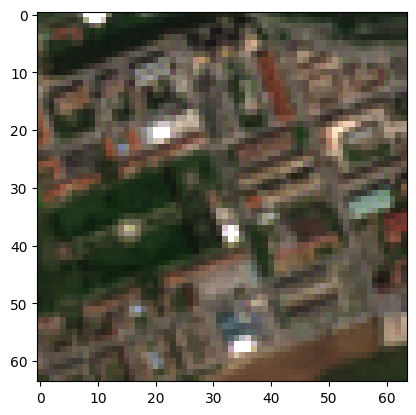

In [26]:
import matplotlib.pyplot as plt
plt.imshow(s2_images[-1]['image'][[3,2,1]].transpose(1,2,0) *(2.5/10000))

In [32]:
## Import the two rasters 
building_pred = "/home/tidop/Descargas/remotesensing-13-03135-s001 (2)/Suplementary/Prediction_building.tif"
road_pred = "/home/tidop/Descargas/remotesensing-13-03135-s001 (2)/Suplementary/Prediction_road.tif"

import rasterio as rio
## Define the widows using the s2 profile
transform = out_arrays[-1]['profile']['transform']
crs = out_arrays[-1]['profile']['crs']
height = out_arrays[-1]['profile']['height']
width = out_arrays[-1]['profile']['width']

bbox = rio.transform.array_bounds(height, width, transform)
print(bbox)

with rio.open(building_pred) as src:
    building_array = src.read(1, window=rio.windows.from_bounds(*bbox, transform=src.transform))

with rio.open(road_pred) as src:
    road_array = src.read(1, window=rio.windows.from_bounds(*bbox, transform=src.transform))

bg_array = np.clip(1.0 - (building_array + road_array), 0, 1)
rgb_array = np.stack([building_array, road_array, bg_array], axis=0)  # (3, H, W)

(607012.3826077239, 4739526.63448041, 607652.3826077239, 4740166.63448041)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.04025..1.705].


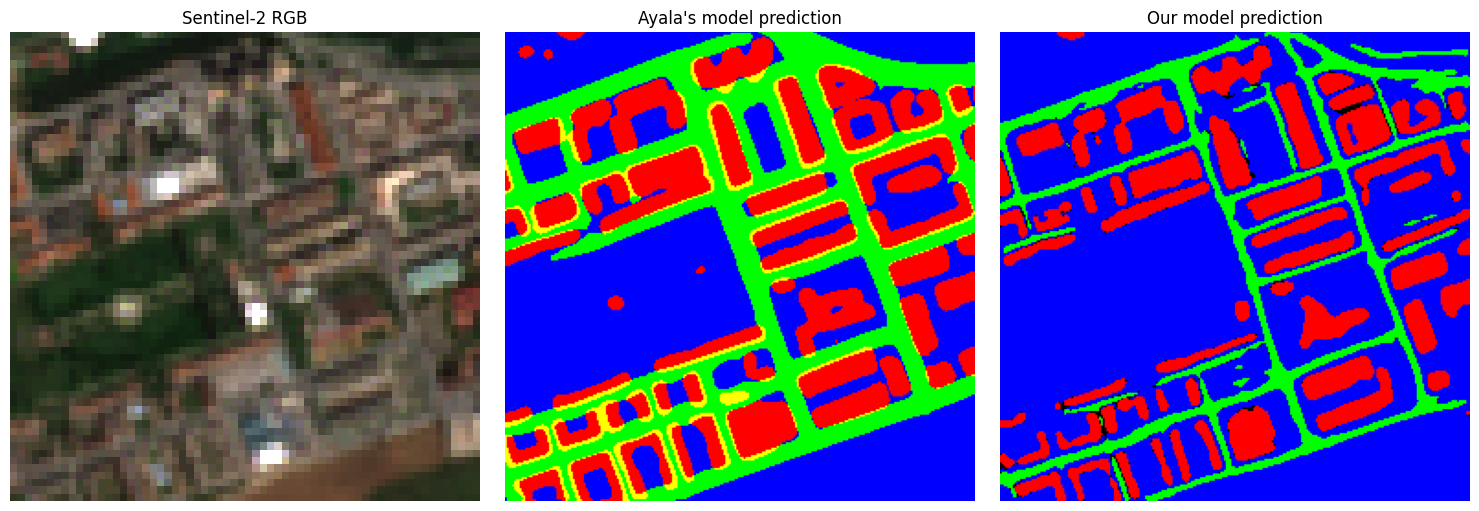

In [42]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].imshow(s2_images[-1]['image'][[3,2,1]].transpose(1,2,0) *(2.5/10000))
axs[0].set_title('Sentinel-2 RGB')
axs[1].imshow(rgb_array.transpose(1,2,0))
axs[1].set_title("Ayala's model prediction")
axs[2].imshow((out_arrays[-1]["pred"] > 0.5).transpose(1,2,0).astype(np.float32))
axs[2].set_title('Our model prediction')
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

In [53]:
rgb1 = np.transpose(s2_images[0]["image"][[3, 2, 1], :, :], (1, 2, 0)) * 2.5 / 10_000
rgb1 = np.clip(rgb1, 0, 1)

arr_br1 = out_arrays[0]
arr_ro1 = out_arrays_only_road[0]
arr_bu1 = out_arrays_only_building[0]

In [27]:
rgb2 = np.transpose(s2_images[1]["image"][[3, 2, 1], :, :], (1, 2, 0)) * 2.2 / 10_000
rgb2 = np.clip(rgb2, 0, 1)

arr_br2 = out_arrays[1]
arr_ro2 = out_arrays_only_road[1]
arr_bu2 = out_arrays_only_building[1]

In [42]:
rgb3 = np.transpose(s2_images[0]["image"][[3, 2, 1], :, :], (1, 2, 0)) * 2.5 / 10_000
rgb3 = np.clip(rgb3, 0, 1)

arr_br3 = out_arrays[0]
arr_ro3 = out_arrays_only_road[0]
arr_bu3 = out_arrays_only_building[0]

NameError: name 'rgb1' is not defined

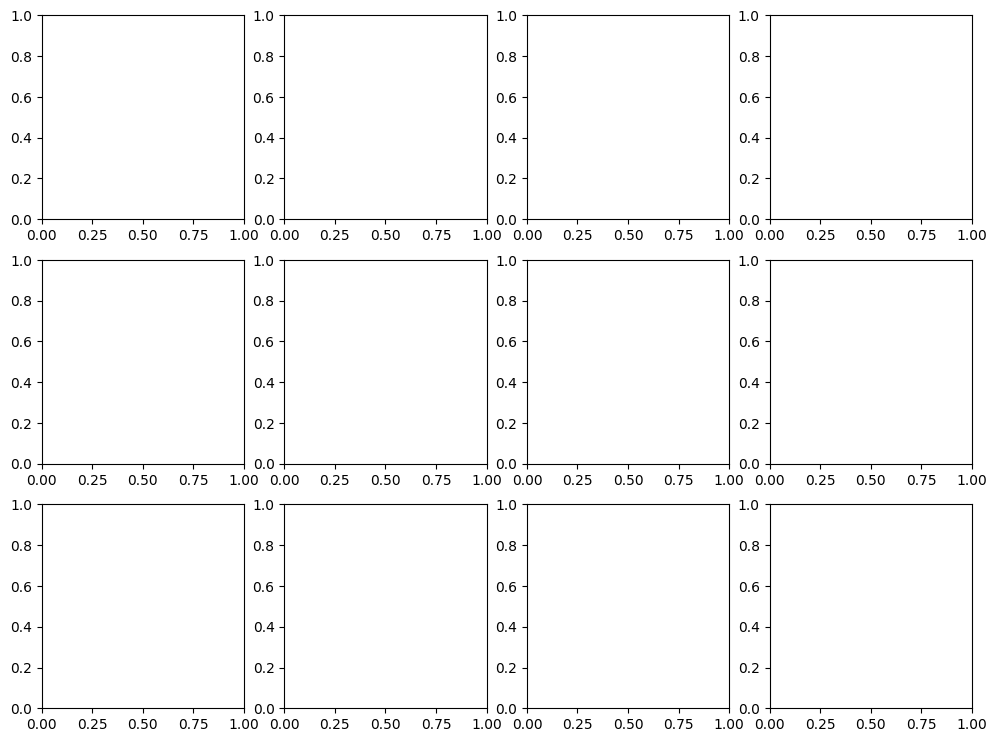

In [ ]:
## Plot results
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 4, figsize=(12, 9))


axs[0, 0].imshow(rgb1)
axs[0, 0].set_title("RGB Image")
axs[0, 0].axis('off')

axs[0, 1].imshow(np.transpose(arr_br1["pred"], (1, 2, 0)))
axs[0, 1].set_title("Collaborative Multitask model")
axs[0, 1].axis('off')

axs[0, 2].imshow(arr_ro1["pred"][0], cmap='viridis')
axs[0, 2].set_title("Road Prediction DLinkNet34")
axs[0, 2].axis('off')

axs[0, 3].imshow(arr_bu1["pred"][0], cmap='viridis')
axs[0, 3].set_title("Building Prediction Unet++")
axs[0, 3].axis('off')

axs[1, 0].imshow(rgb2)
axs[1, 0].axis('off')

axs[1, 1].imshow(np.transpose(arr_br2["pred"], (1, 2, 0)))
axs[1, 1].axis('off')

axs[1, 2].imshow(arr_ro2["pred"][0], cmap='viridis')
axs[1, 2].axis('off')

axs[1, 3].imshow(arr_bu2["pred"][0], cmap='viridis')
axs[1, 3].axis('off')

axs[2, 0].imshow(rgb3)
axs[2, 0].axis('off')

axs[2, 1].imshow(np.transpose(arr_br3["pred"], (1, 2, 0)))
axs[2, 1].axis('off')

axs[2, 2].imshow(arr_ro3["pred"][0], cmap='viridis')
axs[2, 2].axis('off')

axs[2, 3].imshow(arr_bu3["pred"][0], cmap='viridis')
axs[2, 3].axis('off')

plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.01, hspace=0.01)

In [ ]:
bu_ckpt_path = "../checkpoints/unetpp-bestmodel.ckpt"
bu_cfg_path = "../configs/unetpp_config.yaml"  


out_arrays_only_building = []
for i, (s1_arr, s2_arr) in enumerate(zip(s1_images, s2_images)):
    s2_fullbands = np.array(s2_arr["image"])  # (13, H, W)
    s1_np = np.array(s1_arr["image"])  # (2, H, W)

    # Normalize S2 bands to 0-1
    s2_np = s2_fullbands[[3, 2, 1, 7, 10, 11]] / 10_000  # RGB, NIR, SWIR1, SWIR2

    # Combine S2+S1 for input to model
    input_img = np.concatenate((s2_np, s1_np), axis=0)  # (C, H, W)
    mean = np.array(cfg['normalize']['mean']).reshape(-1, 1, 1)
    std = np.array(cfg['normalize']['std']).reshape(-1, 1, 1)
    input_img = (input_img - mean) / std
    input_tensor = torch.tensor(input_img).unsqueeze(0).float()

    # Load model
    ckpt = torch.load(br_ckpt_path, map_location='cpu')
    model = BuildingTrainer(cfg)
    model.load_state_dict(ckpt["state_dict"])
    model.eval()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device).float()
    input_tensor = input_tensor.to(device).float()

    with torch.no_grad():
        build_logits = model(input_tensor)
        build_pred = torch.sigmoid(build_logits).squeeze(0).cpu().numpy()

    # Save the predictions
    out_arrays_only_building.append({
        "date": s2_arr["date"],
        "pred": build_pred,
        "profile": s2_profile
    })

    print(f"Processed image {i+1}/{len(s2_images)}: {s2_arr['date']}")